In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Reads the book_club json file
book_club = pd.read_json('book_club.json', orient='records')
book_club[['meeting','g_published']] = book_club[['meeting','g_published']].apply(lambda x: pd.to_datetime(x, unit='ms'))
book_club.head()

,season,meeting,book,suggestor,james,matt,phil,ryan,sean,kyle,average,goodreads search,audible search,g_rating,g_genre,g_author,g_pages,g_published
0,The Codpiece,2019-06-05,Do Androids Dream of Electric Sheep?,group,5.5,5.0,6.0,5.0,4.6,NaN,5.2,https://www.goodreads.com/search?q=Do+Androids...,https://www.audible.com/search?keywords=Do+And...,4.09,"[Science Fiction, Fiction, Classics, Dystopia,...",Philip K. Dick,258,1968-01-01
1,The Codpiece,2019-07-01,The Call of Cthulhu,group,4.0,4.0,2.5,2.0,1.7,NaN,2.8,https://www.goodreads.com/search?q=The+Call+of...,https://www.audible.com/search?keywords=The+Ca...,3.96,"[Horror, Classics, Fiction, Short Stories, Fan...",H.P. Lovecraft,43,1928-02-01
2,The Codpiece,2019-07-01,Guards! Guards!,group,5.0,1.0,5.7,5.5,5.3,NaN,4.5,https://www.goodreads.com/search?q=Guards!+Gua...,https://www.audible.com/search?keywords=Guards...,4.34,"[Fantasy, Fiction, Humor, Comedy, Dragons, Sci...",Terry Pratchett,376,1989-08-01
3,The Codpiece,2019-07-31,Blood Meridian,phil,6.5,6.0,6.4,NaN,4.3,NaN,5.8,https://www.goodreads.com/search?q=Blood+Merid...,https://www.audible.com/search?keywords=Blood+...,4.16,"[Fiction, Historical Fiction, Westerns, Classi...",Cormac McCarthy,351,1985-04-28
4,The Codpiece,2019-09-15,The Blade Itself,matt,5.7,6.5,NaN,NaN,6.3,NaN,6.2,https://www.goodreads.com/search?q=The+Blade+I...,https://www.audible.com/search?keywords=The+Bl...,3.70,"[Mystery, Fiction, Thriller, Crime, Suspense, ...",Marcus Sakey,320,2007-01-01


In [2]:
members = ['james', 'matt', 'phil', 'ryan', 'sean', 'kyle']
raters = members + ['g_rating']
numbers = book_club[raters + ['meeting','g_pages','g_published']].copy()
numbers['g_rating'] = numbers['g_rating'] / 5 * 7
numbers['polarization'] = numbers[members].std(axis=1)
#numbers['ga_polarization'] = numbers[raters].std(axis=1)

(0.0, 7.0)

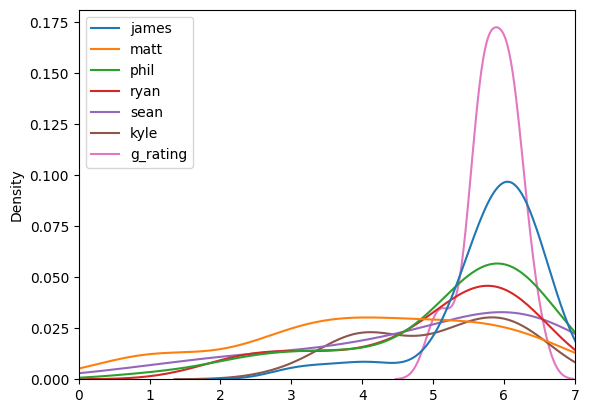

In [3]:
sns.kdeplot(data = numbers[raters])
plt.xlim(xmin=0,xmax=7)

<Axes: >

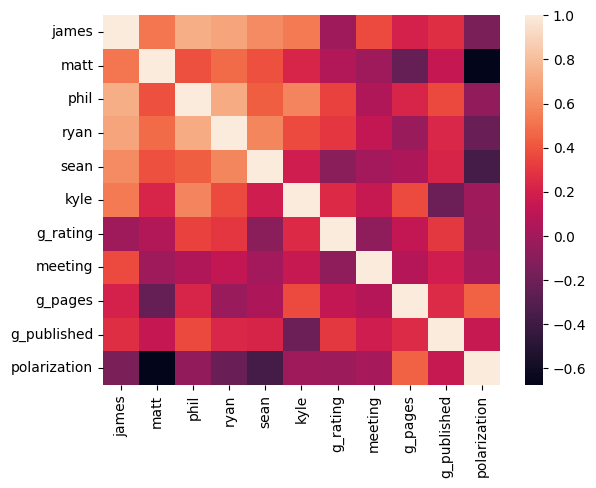

In [4]:
correlations = numbers.corr()
sns.heatmap(correlations)

In [5]:
np.fill_diagonal(correlations.values, np.nan)
correlations = correlations * 100

In [6]:
corr_info = pd.DataFrame({'max_pos_corr' : zip(correlations.idxmax(), round(correlations.max(), 2)),
                          'max_neg_corr' : zip(correlations.idxmin(), round(correlations.min(), 2)),
                          'least_corr' : zip(correlations.abs().idxmin(), round(correlations.abs().min(), 2)), 
                          'most_corr' : zip(correlations.abs().idxmax(), round(correlations.abs().max(), 2))}, 
                         index = correlations.index)
corr_info

,max_pos_corr,max_neg_corr,least_corr,most_corr
james,"(phil, 73.47)","(polarization, -15.13)","(g_rating, 1.42)","(phil, 73.47)"
matt,"(james, 52.15)","(polarization, -67.53)","(meeting, 0.9)","(polarization, 67.53)"
phil,"(james, 73.47)","(polarization, -6.31)","(meeting, 5.35)","(james, 73.47)"
ryan,"(phil, 71.96)","(polarization, -22.33)","(g_pages, 3.18)","(phil, 71.96)"
sean,"(james, 59.67)","(polarization, -36.93)","(meeting, 1.01)","(james, 59.67)"
kyle,"(phil, 56.88)","(g_published, -21.37)","(polarization, 1.95)","(phil, 56.88)"
g_rating,"(phil, 34.38)","(sean, -9.32)","(james, 1.42)","(phil, 34.38)"
meeting,"(james, 36.87)","(g_rating, -6.71)","(matt, 0.9)","(james, 36.87)"
g_pages,"(polarization, 44.75)","(matt, -23.48)","(ryan, 3.18)","(polarization, 44.75)"
g_published,"(phil, 36.36)","(kyle, -21.37)","(matt, 14.13)","(phil, 36.36)"


In [7]:
standard_deviations = numbers.std().drop(['g_published','meeting'])
standard_deviations

james            0.805848
matt             1.753554
phil             1.430707
ryan             1.342812
sean             1.807657
kyle             1.046231
g_rating         0.353543
g_pages         228.77437
polarization     0.514766
dtype: object

In [8]:
exploded_genres = book_club.explode('g_genre').copy()

member_loves = []
member_hates = []
for member in members:
    loves = exploded_genres.groupby('g_genre')[member].mean().sort_values(ascending=False).head().to_dict()
    hates = exploded_genres.groupby('g_genre')[member].mean().sort_values(ascending=True).head().to_dict()
    member_hates.append(pd.DataFrame(list(hates.items()), columns = [member + ' hates', member + ' rating']))
    member_loves.append(pd.DataFrame(list(loves.items()), columns = [member + ' loves', member + ' rating']))
pd.concat(member_loves, axis = 1)

,james loves,james rating,matt loves,matt rating,phil loves,phil rating,ryan loves,ryan rating,sean loves,sean rating,kyle loves,kyle rating
0,Magical Realism,6.60,Food,6.5,School,6.5,Social Justice,6.20,Magical Realism,7.0,Science,6.5
1,LGBT,6.55,Gardening,6.5,Space,6.4,Race,6.20,Space Opera,7.0,Space Opera,6.4
2,Queer,6.50,Cookbooks,6.5,Space Opera,6.3,True Crime,6.15,Cultural,7.0,Cultural,6.4
3,Feminism,6.50,Food and Drink,6.5,Russia,6.3,Business,6.10,Supernatural,6.9,Japan,6.3
4,Historical Fantasy,6.40,Race,6.0,Dystopia,6.3,Politics,6.10,Anthologies,6.9,True Crime,6.3


In [9]:
pd.concat(member_hates, axis = 1)

,james hates,james rating,matt hates,matt rating,phil hates,phil rating,ryan hates,ryan rating,sean hates,sean rating,kyle hates,kyle rating
0,French Literature,3.0,Dragons,1.0,French Literature,1.0,Lovecraftian,2.0,Russia,0.400000,Vampires,3.0
1,Reference,3.5,Role Playing Games,1.0,Gothic,2.0,Slice Of Life,2.2,Politics,0.400000,Role Playing Games,3.0
2,Vampires,3.5,Japan,1.0,Weird Fiction,2.0,Animals,2.4,Animals,1.000000,Reference,3.0
3,Role Playing Games,3.5,Reference,1.0,Games,2.3,Book Club,2.4,Book Club,1.000000,Games,3.0
4,Games,3.5,Comedy,1.0,Reference,2.3,Vampires,2.6,Memoir,1.466667,Sports,3.6


In [10]:
exploded_genres['g_genre'].value_counts().head()

g_genre
Fiction               35
Fantasy               19
Audiobook             18
Classics              12
Historical Fiction    10
Name: count, dtype: int64

In [11]:
exploded_genres['mean'] = exploded_genres[members].mean(axis=1)

In [12]:
exploded_genres[['mean', 'g_genre']].groupby('g_genre').mean().sort_values('mean',ascending=False)

,mean
g_genre,
Space,6.133333
Social Justice,6.100000
Race,6.100000
Space Opera,6.083333
Cultural,6.083333
...,...
Role Playing Games,2.600000
Reference,2.600000
Games,2.600000
